In [4]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2025-11-16 00:50:18.396768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 00:50:18.576660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 00:50:21.377800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
# 1. Load the JSON file
df = pd.read_json("train.json")

# 2. Convert radar bands into 75x75 images
def make_image(row):
    band1 = np.array(row['band_1']).reshape(75, 75)
    band2 = np.array(row['band_2']).reshape(75, 75)
    stacked = np.stack([band1, band2], axis=-1)  # shape: (75,75,2)
    return stacked

X = np.array([make_image(row) for _, row in df.iterrows()])
y = np.array(df["is_iceberg"])

# Optional: replace missing incidence angle with mean
df["inc_angle"] = pd.to_numeric(df["inc_angle"], errors='coerce')
angle_mean = df["inc_angle"].mean()
angles = df["inc_angle"].fillna(angle_mean).values.reshape(-1, 1)

# Append angle as a 3rd channel (optional but helpful)
X = np.concatenate([X, np.repeat(angles[:, None, None, :], 75*75, axis=1).reshape(-1,75,75,1)], axis=-1)

# Normalize
X = (X - X.mean()) / X.std()

# One-hot encode
y = to_categorical(y, num_classes=2)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras import layers, models

def make_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(75,75,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = make_model()
model.summary()


/home/rcs2mh/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-16 00:51:59.071767: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,634 (397.01 KB)

 Trainable params: 101,634 (397.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5331 - loss: 0.6821 - val_accuracy: 0.5140 - val_loss: 0.6712
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5955 - loss: 0.6230 - val_accuracy: 0.6698 - val_loss: 0.6008
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6485 - loss: 0.5773 - val_accuracy: 0.6698 - val_loss: 0.5795
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6687 - loss: 0.5612 - val_accuracy: 0.6729 - val_loss: 0.5659
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6742 - loss: 0.5575 - val_accuracy: 0.6916 - val_loss: 0.5631
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6765 - loss: 0.5523 - val_accuracy: 0.6916 - val_loss: 0.5561
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6851 - loss: 0.5442 - val_accuracy: 0.6916 - val_loss: 0.5539
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6789 - loss: 0.5434 - val_accuracy: 0.6978 - v

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

train_gen = datagen.flow(X_train, y_train, batch_size=32)


In [9]:
history = model.fit(train_gen, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7140 - loss: 0.5433 - val_accuracy: 0.7975 - val_loss: 0.4670
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7342 - loss: 0.5139 - val_accuracy: 0.8255 - val_loss: 0.4543
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7716 - loss: 0.4757 - val_accuracy: 0.7695 - val_loss: 0.4563
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7623 - loss: 0.4643 - val_accuracy: 0.8224 - val_loss: 0.4229
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7880 - loss: 0.4509 - val_accuracy: 0.7819 - val_loss: 0.4438
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7825 - loss: 0.4489 - val_accuracy: 0.7788 - val_loss: 0.4553
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7638 - loss: 0.4530 - val_accuracy: 0.8255 - val_loss: 0.4126
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7794 - loss: 0.4383 - val_accuracy: 0.8318 - v

In [10]:
layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))

<Dense name=dense_2, built=False>

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf

# -----------------------------
# 1. Load the trained model
# -----------------------------
model = tf.keras.models.load_model("iceberg_cnn.h5")
print("Model loaded!")

# -----------------------------
# 2. Load the test.json dataset
# -----------------------------
df_test = pd.read_json("test.json")
print("Test samples:", len(df_test))

# -----------------------------
# 3. Convert radar bands into 75x75 images
# -----------------------------
def make_image(row):
    band1 = np.array(row['band_1']).reshape(75, 75)
    band2 = np.array(row['band_2']).reshape(75, 75)
    stacked = np.stack([band1, band2], axis=-1)  # (75, 75, 2)
    return stacked

X_test = np.array([make_image(row) for _, row in df_test.iterrows()])

# -----------------------------
# 4. Process incidence angle
# -----------------------------
df_test["inc_angle"] = pd.to_numeric(df_test["inc_angle"], errors="coerce")
angle_mean = df_test["inc_angle"].mean()
angles = df_test["inc_angle"].fillna(angle_mean).values.reshape(-1, 1)

# Repeat the angle channel to match spatial dims
angle_channel = np.repeat(angles, 75 * 75).reshape(-1, 75, 75, 1)

# Add as 3rd channel
X_test = np.concatenate([X_test, angle_channel], axis=-1)

# -----------------------------
# 5. Normalize
# (IMPORTANT: same normalization as training)
# -----------------------------
X_test = (X_test - X_test.mean()) / X_test.std()

# -----------------------------
# 6. Predict
# -----------------------------
preds = model.predict(X_test)
iceberg_probs = preds[:, 1]  # Probability image is an iceberg

# -----------------------------
# 7. Format for Kaggle submission
# -----------------------------
submission = pd.DataFrame({
    "id": df_test["id"],
    "is_iceberg": iceberg_probs
})

submission.to_csv("submission.csv", index=False)
print("Saved predictions to submission.csv!")


Model loaded!
Test samples: 8424
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Saved predictions to submission.csv!


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
# Predict class probabilities
y_pred_probs = model.predict(X_val)

# Convert one-hot to class labels
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(y_pred_probs, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


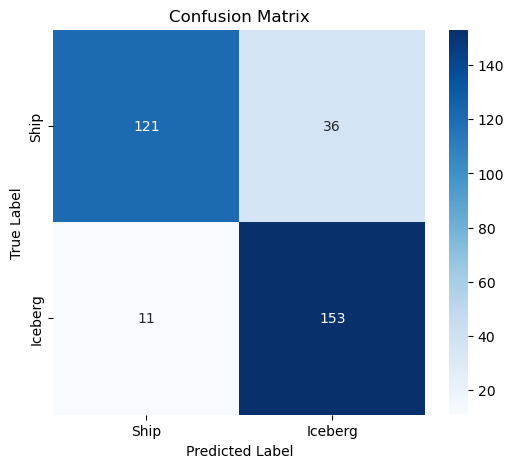

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Ship', 'Iceberg'],
            yticklabels=['Ship', 'Iceberg'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8535825545171339


In [20]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Ship', 'Iceberg']))


Classification Report:
              precision    recall  f1-score   support

        Ship       0.92      0.77      0.84       157
     Iceberg       0.81      0.93      0.87       164

    accuracy                           0.85       321
   macro avg       0.86      0.85      0.85       321
weighted avg       0.86      0.85      0.85       321



In [21]:
auc = roc_auc_score(y_true, y_pred_probs[:, 1])
print("ROC-AUC:", auc)

ROC-AUC: 0.935062917508156


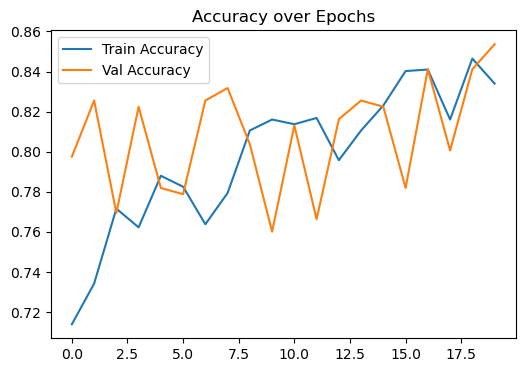

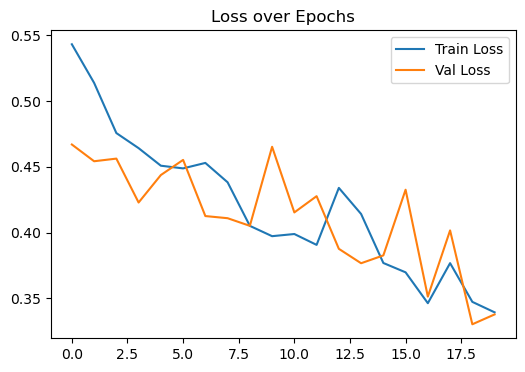

In [22]:
# Accuracy plot
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Loss plot
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()
